In [1]:
import numpy as np
from neural_network.layer import *
from neural_network.net import *
from queue import Queue
import matplotlib.pyplot as plt
from tqdm import tqdm
from neural_network.trainutils import *
import os

In [2]:
current_dir = os.getcwd()
face_dir = os.path.join(current_dir, "cmu+face+images", "faces")
dataset = Dataset(face_dir, flatten=False)

In [3]:
dataset.data.shape

(624, 120, 128)

In [4]:
train_dataset, _, test_dataset = train_test_split(dataset, (0.8, 0.0, 0.2))

In [5]:
len(train_dataset)

499

In [6]:
dataset[500][0].shape

(1, 1, 120, 128)

In [7]:
input_shape = train_dataset[0][0].shape
input_shape

(1, 1, 120, 128)

In [8]:
train_dataset[0]

(array([[[[ 0.60349243,  0.53536997,  0.44685518, ...,  0.58476234,
            0.73022166,  0.55857284],
          [ 0.59138302,  0.5281524 ,  0.44807026, ...,  0.53834402,
            0.50282313,  0.48044742],
          [ 0.77468729,  0.72526659,  0.69241387, ...,  0.4760646 ,
            0.61912279,  0.46699559],
          ...,
          [ 0.27830397,  0.39029519,  0.37121267, ...,  1.28521281,
            1.42869012,  1.52596371],
          [ 0.23795974,  0.37493245,  0.5215035 , ...,  1.26119432,
            1.44492565,  1.53697312],
          [-0.30632073, -0.23481283, -0.02382714, ...,  1.1394964 ,
            1.34456811,  1.49003448]]]]),
 array([[0.],
        [1.],
        [0.],
        [0.]]))

In [9]:
kernel_shape = np.ndarray([1, 1, 3, 3])
pad = 1
stride = 1

conv1 = Conv2D(kernel_shape, pad, stride, layer_id=1) # 120x128
maxpool1 = MaxPool2D(2, 0, 2, conv1) # 60x64
relu1 = ReLU(maxpool1)

conv2 = Conv2D(kernel_shape, pad, stride, relu1, layer_id=2)
maxpool2 = MaxPool2D(2, 0, 2, conv2) # 30x32
relu2 = ReLU(maxpool2)

conv3 = Conv2D(kernel_shape, pad, stride, relu2, layer_id=3)
maxpool3 = MaxPool2D(2, 0, 2, conv3) # 15x16
relu3 = ReLU(maxpool3)

flatten = Flatten(relu3)

linear = Linear(15*16, len(dataset.keys), flatten)
softmax_layer = Softmax(linear)
loss_layer = CrossEntropy(softmax_layer)

model = NeuralNetwork(conv1, softmax_layer, loss_layer)

In [10]:
kernel_shape.shape

(1, 1, 3, 3)

In [11]:
print("Forward order:")
for layer in model._forward_order:
    print(layer)

print("\nBackward order:")
for layer in model._backward_order:
    print(layer)

Forward order:
Conv2D 1: (1, 1, 3, 3), pad=1, stride=1
MaxPool2D: (2, 2), pad=0, stride=2
ReLU
Conv2D 2: (1, 1, 3, 3), pad=1, stride=1
MaxPool2D: (2, 2), pad=0, stride=2
ReLU
Conv2D 3: (1, 1, 3, 3), pad=1, stride=1
MaxPool2D: (2, 2), pad=0, stride=2
ReLU
Flatten
Linear: (240, 1) -> (4, 1)
Softmax
CrossEntropy

Backward order:
CrossEntropy
Softmax
Linear: (240, 1) -> (4, 1)
Flatten
ReLU
MaxPool2D: (2, 2), pad=0, stride=2
Conv2D 3: (1, 1, 3, 3), pad=1, stride=1
ReLU
MaxPool2D: (2, 2), pad=0, stride=2
Conv2D 2: (1, 1, 3, 3), pad=1, stride=1
ReLU
MaxPool2D: (2, 2), pad=0, stride=2
Conv2D 1: (1, 1, 3, 3), pad=1, stride=1


In [12]:
results = k_fold_cross_validation(10, model, train_dataset, epochs=100, lr=1e-3, validation_period=5, seed=585)

Fold 0


[0.00102192]: 100%|██████████| 100/100 [05:24<00:00,  3.24s/it]


Fold 1


[0.00089941]: 100%|██████████| 100/100 [05:27<00:00,  3.27s/it]


Fold 2


[0.00096803]: 100%|██████████| 100/100 [05:22<00:00,  3.23s/it]


Fold 3


[0.00056333]: 100%|██████████| 100/100 [05:25<00:00,  3.26s/it]


Fold 4


[0.00075638]: 100%|██████████| 100/100 [05:23<00:00,  3.23s/it]


Fold 5


[0.00045094]: 100%|██████████| 100/100 [05:24<00:00,  3.24s/it]


Fold 6


[0.00084894]: 100%|██████████| 100/100 [05:24<00:00,  3.24s/it]


Fold 7


[0.00406613]: 100%|██████████| 100/100 [05:23<00:00,  3.23s/it]


Fold 8


[0.00204337]: 100%|██████████| 100/100 [05:25<00:00,  3.25s/it]


Fold 9


[0.00141323]: 100%|██████████| 100/100 [05:15<00:00,  3.15s/it]


In [14]:
import pickle
import datetime
with open(f"results_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pkl", 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(results, outp, pickle.HIGHEST_PROTOCOL)


In [15]:
with open(f"results_2024-05-12-00-32-16.pkl", 'rb') as inp:
    results2 = pickle.load(inp)

In [ ]:
results2

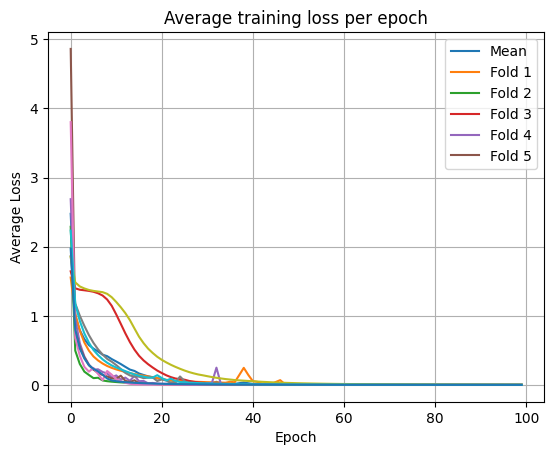

In [17]:
plt.plot(np.mean([res["train_losses"] for res in results], axis=0))

for res in results:
    plt.plot(res["train_losses"])
plt.title("Average training loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend(["Mean", "Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"])
plt.grid()

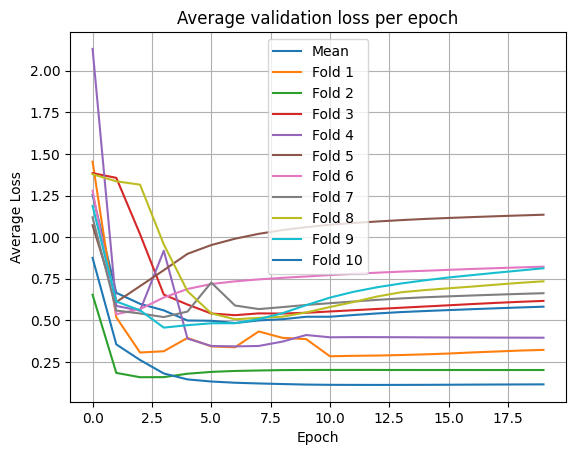

In [21]:
plt.plot(np.mean([res["validation_losses"][::5] for res in results], axis=0))

for res in results:
    plt.plot(res["validation_losses"][::5])
plt.title("Average validation loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend(["Mean"] + [f"Fold {i+1}" for i in range(len(results))])
plt.grid()

In [15]:
unique, counts = np.unique(dataset.label, return_counts=True)

In [25]:
for i in range(10):
    print(f"accuracy {i}: {results[i]['validation_confmats'][-1].trace()/results[i]['validation_confmats'][-1].sum()}")

accuracy 0: 0.94
accuracy 1: 0.96
accuracy 2: 0.92
accuracy 3: 0.92
accuracy 4: 0.82
accuracy 5: 0.88
accuracy 6: 0.88
accuracy 7: 0.84
accuracy 8: 0.86
accuracy 9: 0.96


accuracy: 0.96


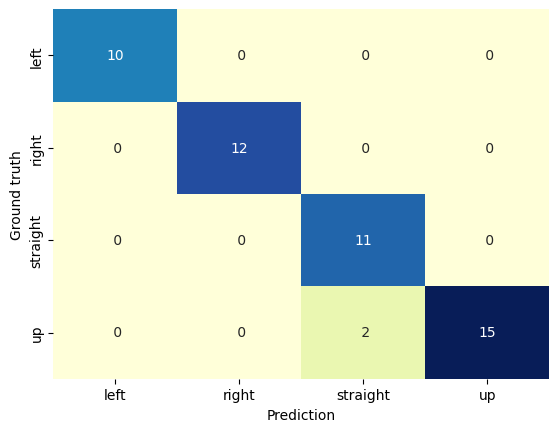

In [27]:
i = 9
import seaborn as sns
print(f"accuracy: {results[i]['validation_confmats'][-1].trace()/results[i]['validation_confmats'][-1].sum()}")

plt.figure()
sns.heatmap(results[i]["validation_confmats"][-1].astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
#plt.title(f"")
plt.show()

accuracy: 0.898


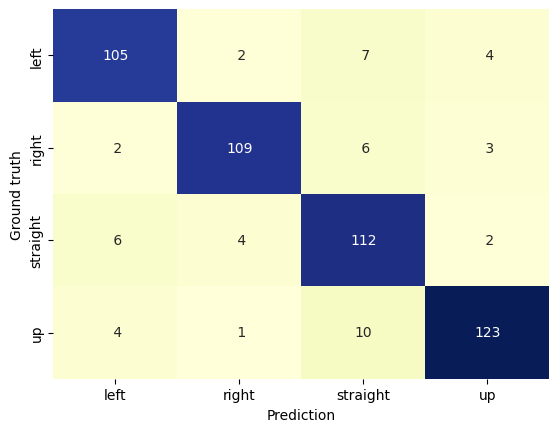

In [30]:
combined_confmat = np.zeros_like(results[0]["validation_confmats"][-1])
for res in results:
    combined_confmat += res["validation_confmats"][-1]

print(f"accuracy: {combined_confmat.trace()/combined_confmat.sum()}")

plt.figure()
sns.heatmap(combined_confmat.astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
#plt.title(f"")
plt.show()

accuracy: 0.94


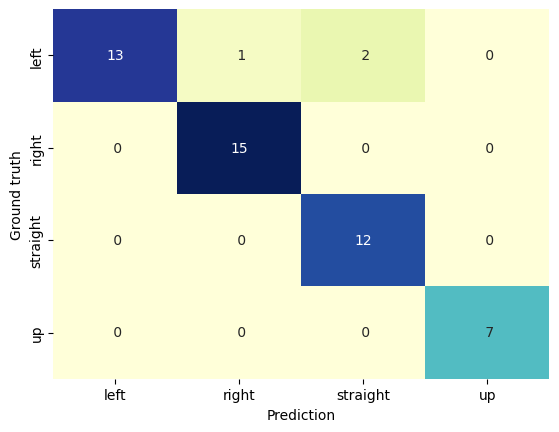

accuracy: 0.96


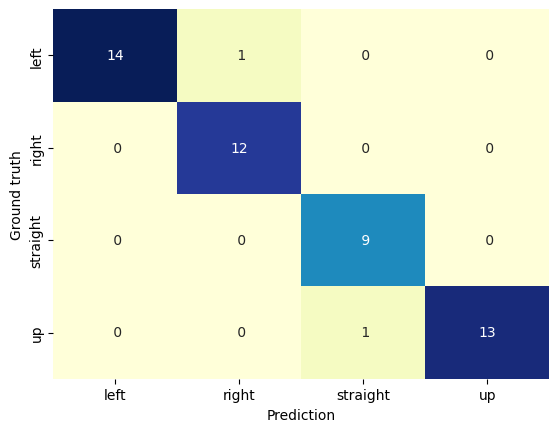

accuracy: 0.92


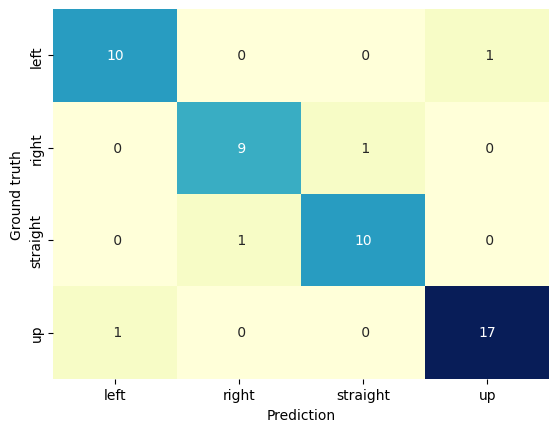

accuracy: 0.92


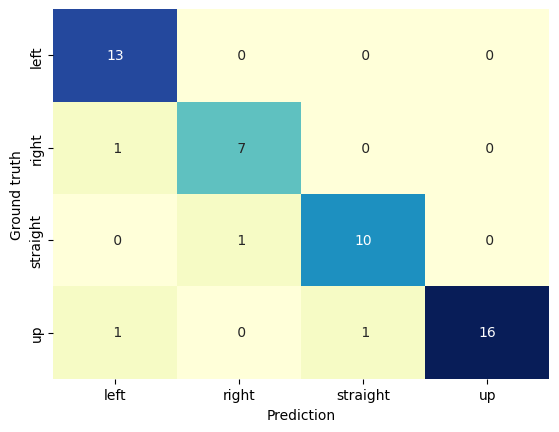

accuracy: 0.82


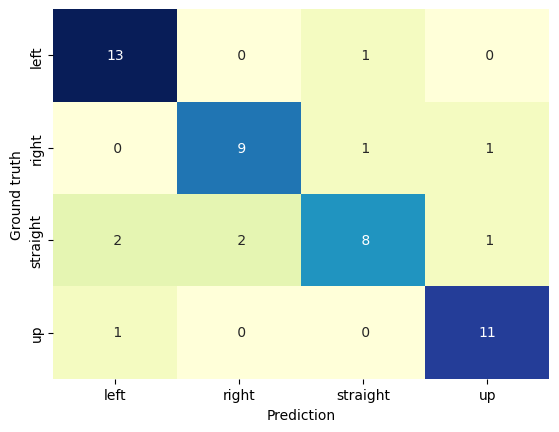

accuracy: 0.88


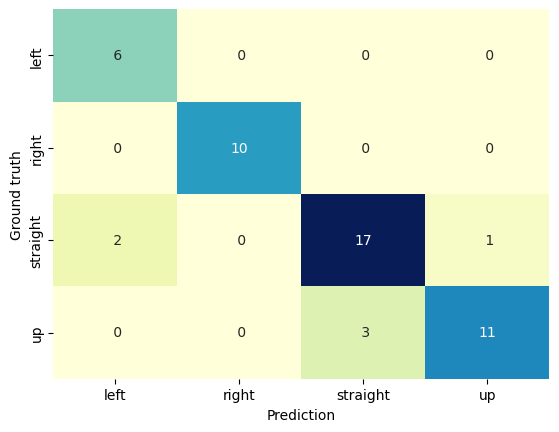

accuracy: 0.88


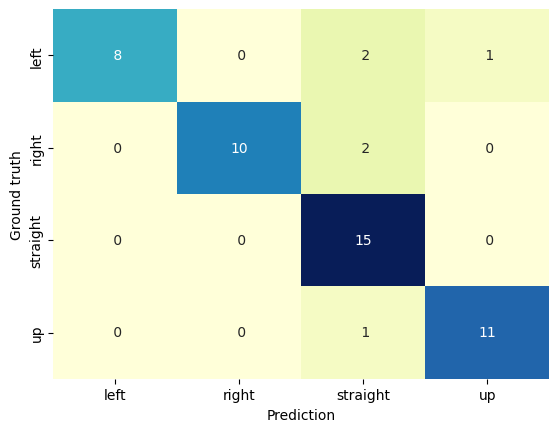

accuracy: 0.84


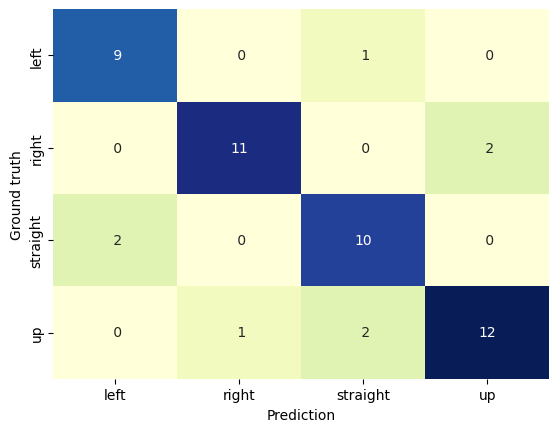

accuracy: 0.86


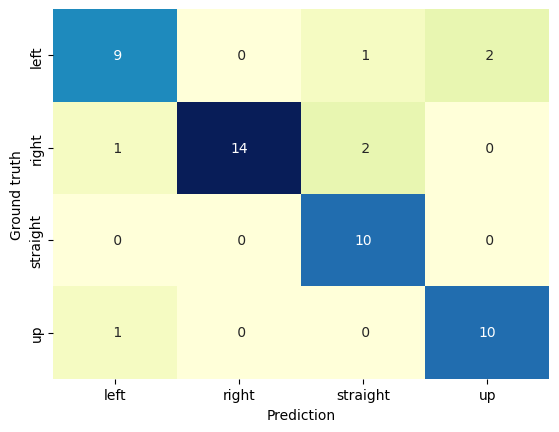

accuracy: 0.96


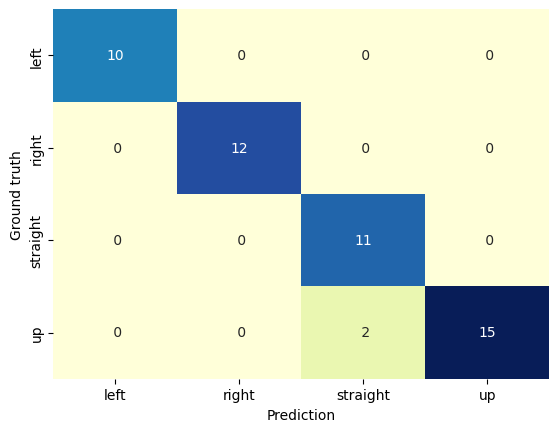

In [34]:
for i in range(10):
    fold_confmat = results[i]["validation_confmats"][-1]
    print(f"accuracy: {fold_confmat.trace()/fold_confmat.sum()}")

    plt.figure()
    sns.heatmap(fold_confmat.astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
    plt.xlabel("Prediction")
    plt.ylabel("Ground truth")
    #plt.title(f"")
    plt.show()

In [16]:
print(dataset.keys[unique])
print(counts)

['left' 'right' 'straight' 'up']
[157 155 156 156]


In [17]:
from PIL import Image
my_img = Image.open("test/woman_straight.jpg").convert("L")
my_img = np.array(my_img)#.reshape(-1, 1)
my_img.shape

(32, 30)

In [32]:
best_model = results[1]["model"]
test_loss = 0
test_confmat = np.zeros((len(test_dataset.keys), len(test_dataset.keys)))
for data, label in test_dataset:
    #data = data.reshape(-1, 1)
    out = model.forward(data)
    loss = model.loss_layer.forward(out, label)
    test_loss += loss
    test_confmat[np.argmax(label), np.argmax(out)] += 1

test_loss = test_loss / len(test_dataset)

Test loss: [0.17998426]
accuracy: 0.96


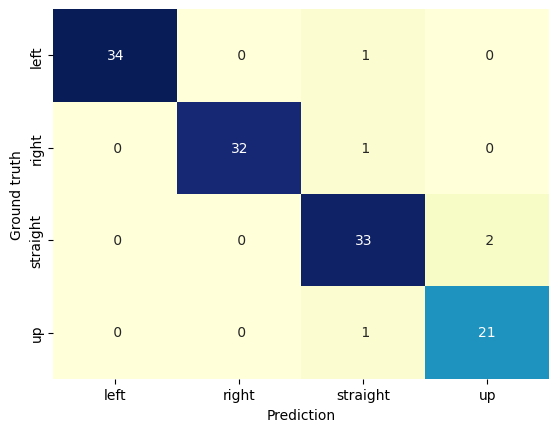

In [33]:
print("Test loss:", test_loss)

print(f"accuracy: {test_confmat.trace()/test_confmat.sum()}")

plt.figure()
sns.heatmap(test_confmat.astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
#plt.title(f"")
plt.show()